# Imports

In [11]:
# Import pandas
import pandas as pd

# Import matplotlib
import matplotlib.pyplot as plt

# Import numpy
import numpy as np 

# Import Network X
import networkx as nx

# Getting the data

## Paths for in.out files

In [12]:
# Path of IN-labels
mesh_path = '../../data/final/mesh.pkl'

# Path for IN-tags
geo_path = '../../data/final/geo.pkl'

# Path for IN-tags-restful
rest_path = '../../data/final/geo_restful_chem.pkl'

## Read geo_df and mesh_df

In [13]:
# Read MeSH
mesh_df = pd.read_pickle(mesh_path)

# Read GEO
geo_df = pd.read_pickle(geo_path)

# Read Restful API
rest_df = pd.read_pickle(rest_path)

In [14]:
# Separate Diseases
geo_C = geo_df[geo_df['category']=='C']
geo_D = geo_df[geo_df['category']=='D']

# Find new tags for drugs
geo_D_rest = pd.merge(
    geo_D, 
    rest_df['mesh_id disease_tag_from_tagger'.split()].drop_duplicates(), 
    how='inner', 
    on='mesh_id')
geo_D_rest.drop(columns='mesh_heading', inplace=True)
geo_D_rest = geo_D_rest['geo_id nsamples date mesh_id disease_tag_from_tagger category method'.split()]
geo_D_rest.rename(columns={'disease_tag_from_tagger':'mesh_heading'}, inplace=True)

# Concatenate them into new geo_df
geo_df = pd.concat([geo_C, geo_D_rest])

# Echo
geo_df.head()

,geo_id,nsamples,date,mesh_id,mesh_heading,category,method
10,200000001,38,2001/01/22,D014604,Uveal Neoplasms,C,pmid
11,200000001,38,2001/01/22,D012878,Skin Neoplasms,C,pmid
12,200000001,38,2001/01/22,D008545,Melanoma,C,pmid
13,200000001,38,2001/01/22,D018450,Disease Progression,C,pmid
15,200000001,38,2001/01/22,D009361,Neoplasm Invasiveness,C,pmid


## Compute category-depth

In [15]:
# Construct grand AstraZeneca dataframe
az_df = pd.merge(geo_df, mesh_df, on='mesh_id')

# Drop extra columns from merge
az_df.drop(columns='mesh_heading_y category_y method'.split(), inplace=True)

# Rename merge column
az_df.rename(columns={'mesh_heading_x':'mesh_heading'}, inplace=True)

# Calculate category - Again
az_df['category']=az_df['mesh_treenumbers'].str.split('.').str[0].str[0]

# Report on propperly classified MeSH-ids category-wise
Propper_Tags = list(az_df['category_x']==az_df['category']).count(True)
Total_Tags = az_df['category_x'].shape[0]
print('Correctly categorized MeSH ids: {:4.1f}%'.format(100*Propper_Tags/Total_Tags))

# Calculate category depth
az_df['depth']=az_df['mesh_treenumbers'].str.split('.').str.len()

# Drop old-category column
az_df.drop(columns='category_x'.split(), inplace=True)

# Echo
az_df.head()

Correctly categorized MeSH ids: 97.3%


,geo_id,nsamples,date,mesh_id,mesh_heading,mesh_treenumbers,category,depth
0,200000001,38,2001/01/22,D014604,Uveal Neoplasms,C04.588.364.978,C,4
1,200000001,38,2001/01/22,D014604,Uveal Neoplasms,C11.319.494,C,3
2,200000001,38,2001/01/22,D014604,Uveal Neoplasms,C11.941.855,C,3
3,200022138,63,2010/12/14,D014604,Uveal Neoplasms,C04.588.364.978,C,4
4,200022138,63,2010/12/14,D014604,Uveal Neoplasms,C11.319.494,C,3


## Filter and Clean geo DataFrame

In [16]:
# Construct date filter 
mask_date = az_df['date']==az_df['date'] # Take all studies

# Construct category filter
mask_category = ((az_df['category']=='C') | (az_df['category']=='D')) # Drugs and Diseases

# Construct mask to filter high-general categories
mask_depth = True #((az_df['depth']>=2) & (az_df['depth']>=2))

# Construct mask to avoid specific categories
mask_c23 = ~az_df['mesh_treenumbers'].str.startswith('C23', na=False)
mask_avoid_cats = mask_c23

# Apply filters
filtered_geo_df = pd.DataFrame(az_df[mask_date & mask_category & mask_depth & mask_avoid_cats])

# Eliminate filterning columns
filtered_geo_df.drop(columns='date mesh_treenumbers depth'.split(), inplace=True)

# Drop NaNs
filtered_geo_df.dropna(axis=0, inplace=True)

# Drop duplicates
filtered_geo_df.drop_duplicates(inplace=True)

# Only select summaries with +1 tag
tags_by_summary = filtered_geo_df['geo_id mesh_id'.split()].groupby('geo_id').count().reset_index() # Count tags per summary
good_summaries = tags_by_summary[tags_by_summary['mesh_id']>1] # Select abstracts with more than one tag
clean_geo = pd.merge(filtered_geo_df, good_summaries, on='geo_id') # Inner Join
clean_geo = clean_geo.drop(columns='mesh_id_y') # Drop column from inner join
clean_geo = clean_geo.rename(columns={'mesh_id_x':'mesh_id'}) # Rename key column

# Write info
print('Number of Records: ',clean_geo.shape[0])

# Echo
clean_geo.head()

Number of Records:  187676


,geo_id,nsamples,mesh_id,mesh_heading,category
0,200000001,38,D014604,Uveal Neoplasms,C
1,200000001,38,D012878,Skin Neoplasms,C
2,200000001,38,D008545,Melanoma,C
3,200000001,38,D009361,Neoplasm Invasiveness,C
4,200022138,63,D014604,Uveal Neoplasms,C


# Constructing the Disease-Drug Graph

## Construct Nodes

In [17]:
# Select only relevant columns
nodes = pd.DataFrame(clean_geo['mesh_id category mesh_heading'.split()])

# Drop duplicates
nodes.drop_duplicates(inplace=True, keep='first')

# Echo
nodes.head()

,mesh_id,category,mesh_heading
0,D014604,C,Uveal Neoplasms
1,D012878,C,Skin Neoplasms
2,D008545,C,Melanoma
3,D009361,C,Neoplasm Invasiveness
6,D009369,C,Neoplasms


## Construct Edges

In [18]:
# Construct all-with-all links inside same geoid-nsample-date record
links = pd.merge(clean_geo, clean_geo, on='geo_id nsamples'.split())

# Rename to Source-Target
links.rename(columns={'mesh_id_x':'source', 'mesh_id_y':'target'}, inplace=True)

# Delete self-linkage
links.drop(links[links['source']==links['target']].index, inplace=True)

# Collapse repetitions while calculating weights
edges = links.groupby('source target'.split()).sum().reset_index()

# Rename sum(nsamples) to 'weight'
edges.rename(columns={'nsamples':'weight'}, inplace=True)

# Account for mirror-duplicates
edges['weight']/=2

# Normalize weights
edges['weight']/=edges['weight'].max()

# Head
edges.head()

,source,target,weight
0,D000001,D000230,0.000002
1,D000001,D002110,0.000004
2,D000001,D002118,0.000305
3,D000001,D006474,0.000003
4,D000001,D011471,0.000002


## Construct Graph

In [22]:
# Construct Directed Graph
dd = nx.from_pandas_edgelist(edges, 
                             source='source', 
                             target='target', 
                             edge_attr='weight', 
                             create_using=nx.DiGraph()
                            )

# Transform to undirected graph
dd = nx.to_undirected(dd)

# Add nodes attributes - Category
nx.set_node_attributes(dd, nodes['mesh_id category'.split()].set_index('mesh_id').to_dict()['category'], 'category')

# Add nodes attributes - Mesh Heading
nx.set_node_attributes(dd, nodes['mesh_id mesh_heading'.split()].set_index('mesh_id').to_dict()['mesh_heading'], 'mesh_heading')

# Save as pickle
nx.write_gpickle(dd,'Gephi_DD.pkl')

# Save to gephi
nx.write_gexf(dd,'Gephi_DD.gexf')

# Echo info
print('  Size (Nodes): ', dd.size())
print(' Order (Edges): ', dd.order())
print(' Graph Density: ', nx.density(dd))

  Size (Nodes):  76632
 Order (Edges):  2915
 Graph Density:  0.018043137111784242


## Define some useful functions over the tree

In [21]:
def get_categories(graph):
    """
    Get a dictionary with the categories of all the nodes
    """
    return nx.get_node_attributes(graph, 'category')
   
    
def get_mesh_headings(graph):
    """
    Get a dictionary with the mesh-headings of all the nodes
    """
    return nx.get_node_attributes(graph, 'mesh_heading')
    

def get_neighbors(graph, node, cats):
    """
    Get the neighbors of the node such that they have the same/opposite category
    """
        
    # Define empty lists
    same = list()
    oppo = list()
        
    # Select only those with same category
    for neigh in nx.neighbors(dd, node):
            
        # Check for same neighbors
        if cats[neigh]==cats[node]:
            same.append(neigh)
        else:
            oppo.append(neigh)
                
    # Return the tuples same and oppo
    return same, oppo
    
    
def get_top(dictionary_metric, top):
    """
    Find the top-n nodes according to some metric
    """
    
    # Get the items in the metric dictionary
    items = list(dictionary_metric.items())
    
    # Sort them out
    items.sort(reverse=True, key=lambda x: x[1])
    
    # Return the keys
    return list(map(lambda x:x[0], items[:top]))


def get_only(graph, cats, specific_category):
    """
    Select the nodes of the graph where category==category and returns a subgraph
    """
    
    # Define empty list
    only_nodes = list()
    
    # Cycle through the nodes
    for node in graph.nodes():
        if cats[node]==specific_category:
            only_nodes.append(node)
    
    # Return the subgraph
    return nx.subgraph(graph, only_nodes)  

# Recomend drugs for top diseases ['C']

## Select diseases

In [23]:
# Read full graph
ee = nx.read_gpickle('Gephi_DD.pkl')

# Read categories and labels
cats = get_categories(graph=ee)
labs = get_mesh_headings(graph=ee)

# Choose only disease-nodes
diseases = get_only(graph=ee, cats=cats, specific_category='C')

## Runs stats on diseases

In [24]:
# Disease eigenvector centrality
diseases_eig = nx.eigenvector_centrality(diseases, max_iter=500, weight='weight')

# Disease PageRank 
diseases_pgn = nx.pagerank(diseases, alpha=0.9, weight='weight')

# Disease Degree 
diseases_deg = nx.degree_centrality(diseases)

## Choose n-top disease nodes

In [25]:
# Find top-diseases
top = 100
top_eig = get_top(dictionary_metric=diseases_eig, top=top)
top_pgn = get_top(dictionary_metric=diseases_pgn, top=top)
top_deg = get_top(dictionary_metric=diseases_deg, top=top)
top_diseases = top_eig

## Measure recommendation-strenght (rs)

In [26]:
# Define containers of important recommendations
rs = list()

# Choose a node
for disease in top_diseases:

    # Get neighbors diseases and neighboring drugs
    nei_dis, nei_dru = get_neighbors(graph=dd, node=disease, cats=cats)

    # Get max possible weight
    ww_max = sum([dd.get_edge_data(disease, nei, 'weight')['weight'] for nei in nei_dis])
    
    # For every neighboring disease
    for n_disease in nei_dis:

        # Find all the neighboring drugs 
        _ , nei_nei_dru = get_neighbors(graph=dd, node=n_disease, cats=cats) 

        # Chose drugs not in nei_dru
        not_in_nei_dru = list(set(nei_nei_dru) - set(nei_dru))

        # Add them to rs with weight
        c1 = [disease]*len(not_in_nei_dru)
        c2 = not_in_nei_dru
        ww = dd.get_edge_data(disease, n_disease, 'weight')['weight']
        c3 = [ww/ww_max]*len(not_in_nei_dru)
        
        rs.extend(zip(c1, c2, c3))

# Get into a DF
rs = pd.DataFrame(data=rs, columns='Disease Drug Recommendation_Strenght'.split())

# Group by disease-drug pairs and add the weights
rs = pd.DataFrame(rs.groupby('Disease Drug'.split()).sum().reset_index())

# Clean duplicates
rs = rs.drop_duplicates().reset_index(drop=True)

# Add names to mesh_ids
rs['Disease_Name'] = [labs[node] for node in rs.Disease]
rs['Drug_Name'] = [labs[node] for node in rs.Drug]

# Rearrange
rs = rs['Disease Disease_Name Drug Drug_Name Recommendation_Strenght'.split()]

# Sort by r-strenght
rs.sort_values(by='Recommendation_Strenght Disease Drug'.split(), inplace=True, ascending=False)

# Reset index
rs.reset_index(inplace=True, drop=True)

# Echo
print('Size of rs: ', rs.shape)
rs.head(25)

Size of rs:  (50160, 5)


,Disease,Disease_Name,Drug,Drug_Name,Recommendation_Strenght
0,D010182,Pancreatic Diseases,D016212,TGFbetaPRMT5MEP50,1.000000
1,D010182,Pancreatic Diseases,D016207,Disparate Innate Cytokine,1.000000
2,D010182,Pancreatic Diseases,D005947,glucose DMEM,1.000000
3,D010182,Pancreatic Diseases,D036341,AutocrineParacrine,0.999608
4,D010182,Pancreatic Diseases,D015415,Bethyl Laboratories 300202A,0.999608
5,D010182,Pancreatic Diseases,D005557,formaldehyde Formaldehyde,0.999608
6,D010182,Pancreatic Diseases,D005227,fatty acid palmitate,0.999608
7,D010182,Pancreatic Diseases,D019788,18FDG PETCT,0.999215
8,D010182,Pancreatic Diseases,D014409,TNFalpha glucocorticoids,0.999215
9,D010182,Pancreatic Diseases,D000596,Amino acids,0.999215


## Visualization of rs

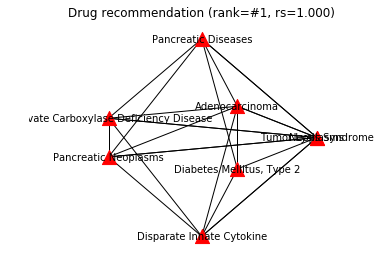

In [47]:
# Choose input
cardinality = 1

# Get nodes
dis_node = rs['Disease'].iloc[cardinality]
dru_node = rs['Drug'].iloc[cardinality]
dis_neighs, _ = get_neighbors(graph=ee, node=dis_node, cats=cats)

# Gather nodes
my_nodes = [dis_node, dru_node]
my_nodes.extend(dis_neighs)

# Gather categories
my_cats={node:cats[node] for node in my_nodes}
        
# Gather labels
my_labs={node:labs[node] for node in my_nodes}

# Gather positions
eps = 3
angle = np.linspace(0, 2*np.pi, len(my_nodes)-2)
radius = np.ones(len(my_nodes)-2)
x_pos, y_pos = radius*np.cos(angle), radius*np.sin(angle)
my_poss=dict()
my_poss[dis_node]=(0, +eps)
my_poss[dru_node]=(0, -eps)
for i in range(len(my_nodes)-2):
    my_poss[dis_neighs[i]]=(x_pos[i], y_pos[i])

# Construct subgraph
ee_sub = ee.subgraph(my_nodes)

# Modify original node
ee_sub.nodes[dis_node]['category']='X'

# Export subgraph to gephi
nx.write_gexf(ee_sub, 'dru_rec/drug_recommendation_{:07d}.gexf'.format(cardinality))

# Plot
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])

nx.draw_networkx_labels(ee_sub, pos=my_poss, labels=my_labs, font_size=10)
nx.draw_networkx(ee_sub, pos=my_poss, node_size=200, node_shape='^', with_labels=False)

titulo='Drug recommendation (rank=#{:}, rs={:3.3f})'.format(
    cardinality,
    rs['Recommendation_Strenght'].iloc[cardinality])
axes.set_title(titulo)
axes.set_xlim(-1.5,1.5)
axes.set_ylim(-3.5,3.5)

plt.axis('off')
plt.savefig('dru_rec/drug_recommendation_{:07d}.png'.format(cardinality), dpi=500)
plt.show()

# Recomend disease for top drug ['D']

## Select drugs

In [65]:
# Read full graph
ee = nx.read_gpickle('Gephi_DD.pkl')

# Read categories and labels
cats = get_categories(graph=ee)
labs = get_mesh_headings(graph=ee)

# Choose only drug-nodes
drugs = get_only(graph=ee, cats=cats, specific_category='D')

## Runs stats on drugs

In [66]:
# Drugs eigenvector centrality
drugs_eig = nx.eigenvector_centrality(drugs, max_iter=500, weight='weight')

# Drugs PageRank 
drugs_pgn = nx.pagerank(drugs, alpha=0.9, weight='weight')

# Drugs Degree 
drugs_deg = nx.degree_centrality(drugs)

## Select n-top drugs

In [67]:
# Find top-diseases
top = 100
top_eig = get_top(dictionary_metric=drugs_eig, top=top)
top_pgn = get_top(dictionary_metric=drugs_pgn, top=top)
top_deg = get_top(dictionary_metric=drugs_deg, top=top)
top_drugs = top_eig

## Compute recommendation-strenght (rs)

In [68]:
# Define containers of important recommendations
rs = list()

# Choose a node
for drug in top_drugs:

    # Get neighbors diseases and neighboring drugs
    nei_dru, nei_dis = get_neighbors(graph=dd, node=drug, cats=cats)

    # Get max possible weight
    ww_max = sum([dd.get_edge_data(drug, nei, 'weight')['weight'] for nei in nei_dru])
    
    # For every neighboring drug
    for n_drug in nei_dru:

        # Find all the neighboring diseases 
        _, nei_nei_dis = get_neighbors(graph=dd, node=n_drug, cats=cats) 

        # Chose disease not in nei_dis
        not_in_nei_dis = list(set(nei_nei_dis) - set(nei_dis))

        # Add them to rs with weight
        c1 = [drug]*len(not_in_nei_dis)
        c2 = not_in_nei_dis
        ww = dd.get_edge_data(drug, n_drug, 'weight')['weight']
        c3 = [ww/ww_max]*len(not_in_nei_dis)
        
        rs.extend(zip(c1, c2, c3))


# Get into a DF
rs = pd.DataFrame(data=rs, columns='Drug Disease Recommendation_Strenght'.split())

# Group by disease-drug pairs and add the weights
rs = pd.DataFrame(rs.groupby('Drug Disease'.split()).sum().reset_index())

# Clean duplicates
rs = rs.drop_duplicates().reset_index(drop=True)

# Add names to mesh_ids
rs['Drug_Name'] = [labs[node] for node in rs.Drug]
rs['Disease_Name'] = [labs[node] for node in rs.Disease]

# Rearrange
rs = rs['Drug Drug_Name Disease Disease_Name Recommendation_Strenght'.split()]

# Sort by r-strenght
rs.sort_values(by='Recommendation_Strenght Drug Disease'.split(), inplace=True, ascending=False)

# Reset index
rs.reset_index(inplace=True, drop=True)

# Echo
print('Size of rs: ', rs.shape)
rs.head(25)

Size of rs:  (67273, 5)


,Drug,Drug_Name,Disease,Disease_Name,Recommendation_Strenght
0,D007659,ketone,D015658,HIV Infections,1.0
1,D007659,ketone,D010190,Pancreatic Neoplasms,1.0
2,D007659,ketone,D008545,Melanoma,1.0
3,D007659,ketone,D006528,"Carcinoma, Hepatocellular",1.0
4,D007659,ketone,D004195,"Disease Models, Animal",1.0
5,D007659,ketone,D003110,Colonic Neoplasms,1.0
6,D007659,ketone,D000230,Adenocarcinoma,1.0
7,D007069,IFX tocilizumab TCZ,D009369,Neoplasms,1.0
8,D024841,fluoroquinolones trovafloxacin,D016403,"Lymphoma, Large B-Cell, Diffuse",1.0
9,D024841,fluoroquinolones trovafloxacin,D015470,"Leukemia, Myeloid, Acute",1.0


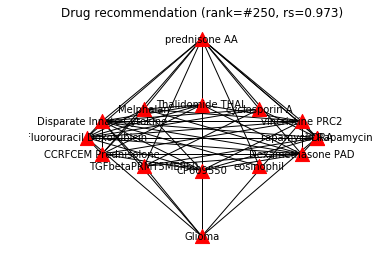

In [70]:
# Choose input
cardinality = 250

# Get nodes
dru_node = rs['Drug'].iloc[cardinality]
dis_node = rs['Disease'].iloc[cardinality]
dru_neighs, _ = get_neighbors(graph=ee, node=dru_node, cats=cats)

# Gather nodes
my_nodes = [dru_node, dis_node]
my_nodes.extend(dru_neighs)

# Gather categories
my_cats={node:cats[node] for node in my_nodes}
        
# Gather labels
my_labs={node:labs[node] for node in my_nodes}

# Gather positions
eps = 3
angle = np.linspace(0, 2*np.pi, len(my_nodes)-2)
radius = np.ones(len(my_nodes)-2)
x_pos, y_pos = radius*np.cos(angle), radius*np.sin(angle)
my_poss=dict()
my_poss[dru_node]=(0, +eps)
my_poss[dis_node]=(0, -eps)
for i in range(len(my_nodes)-2):
    my_poss[dru_neighs[i]]=(x_pos[i], y_pos[i])

# Construct subgraph
ee_sub = ee.subgraph(my_nodes)

# Modify original node
ee_sub.nodes[dru_node]['category']='X'

# Export subgraph to gephi
nx.write_gexf(ee_sub, 'dis_rec/second_use_recommendation_{:07d}.gexf'.format(cardinality))

# Plot
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])

nx.draw_networkx_labels(ee_sub, pos=my_poss, labels=my_labs, font_size=10)
nx.draw_networkx(ee_sub, pos=my_poss, node_size=200, node_shape='^', with_labels=False)

titulo='Drug recommendation (rank=#{:}, rs={:3.3f})'.format(
    cardinality,
    rs['Recommendation_Strenght'].iloc[cardinality])
axes.set_title(titulo)
axes.set_xlim(-1.5,1.5)
axes.set_ylim(-3.5,3.5)

plt.axis('off')
plt.savefig('dis_rec/second_use_recommendation_{:07d}.png'.format(cardinality))
plt.show()

# End